In [4]:
# Cell 1: Setup and load model
import sys, json, glob, random
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

# Setup paths
BASE_DIR = Path.cwd()
SRC_DIR = BASE_DIR.parent / "src"
sys.path.append(str(SRC_DIR))

# Configuration
MODEL_PATH = "../data/model/best_model.pt"
TEST_PROFILES_PATH = "../data/model/test_profiles.json"
TEST_DATA_PATH = "../data/normalized_profiles"
NORM_METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
OUTPUT_DIR = "../figures/"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Load model and config
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
config = checkpoint['config']
model_state = checkpoint['state_dict']

# Get variable names and load model
input_vars = config['input_variables']
target_vars = config['target_variables']
thermal_feature, reflected_feature = "thermal_net_flux", "reflected_net_flux"
plot_coord_var = "pressure"

from model import create_prediction_model
model = create_prediction_model(config)
model.load_state_dict(model_state)
model.eval()

# Load normalization metadata
with open(NORM_METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Get test files
try:
    with open(TEST_PROFILES_PATH, 'r') as f:
        test_files = [(Path(TEST_DATA_PATH) / name) for name in json.load(f)]
except FileNotFoundError:
    test_files = [Path(f) for f in glob.glob(f"{TEST_DATA_PATH}/*.json") 
                  if Path(f).name != "normalization_metadata.json"]

/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_77710/463942627.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_locat

29.3428897857666
25.461196899414062
22.134065628051758
24.82891082763672
22.633075714111328


(-10000000000.0, 10000000000.0)

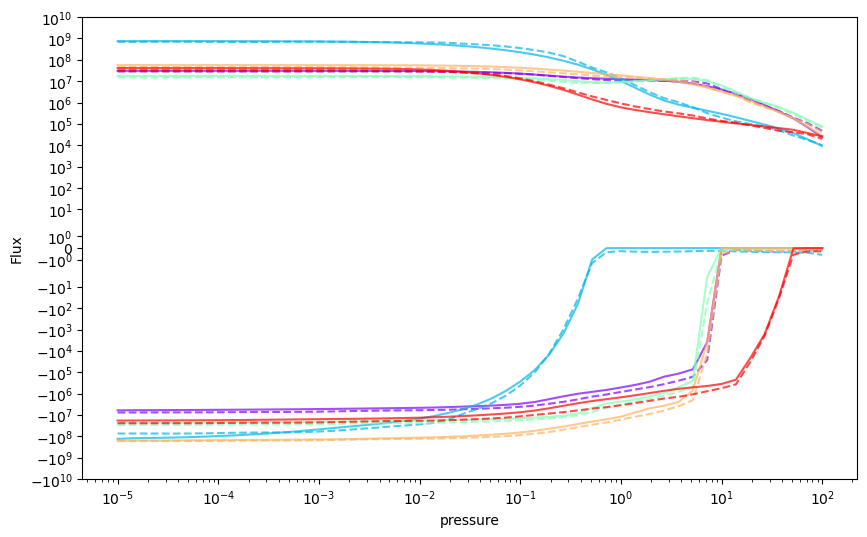

In [5]:
import time

from normalizer import DataNormalizer

plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, 5))

for file_path, color in zip(test_files[:10], colors):
    if not file_path.exists():
        continue
        
    # Load profile and extract coordinates
    with open(file_path, 'r') as f:
        profile = json.load(f)
    
    coord_vals = profile.get(plot_coord_var, list(range(100)))
    seq_len = len(coord_vals) if isinstance(coord_vals, list) else 100
    coord_denorm = DataNormalizer.denormalize(coord_vals, metadata, plot_coord_var) if isinstance(coord_vals, list) else list(range(seq_len))
    
    # Prepare inputs
    inputs = []
    for var in input_vars:
        val = profile.get(var, 0)
        values = val[:seq_len] if isinstance(val, list) else [float(val)] * seq_len
        values = values + [0] * (seq_len - len(values)) if len(values) < seq_len else values[:seq_len]
        inputs.append(torch.tensor(values, dtype=torch.float32))
    
    # Run model with variable output length
    input_tensor = torch.stack(inputs, dim=1).unsqueeze(0)
    with torch.no_grad():
        start_time = time.time()
        predictions = model(input_tensor, target_seq_length=seq_len)
        end_time = time.time()

        print((end_time - start_time) * 1000)
    
    # Extract and denormalize data
    thermal_idx, reflected_idx = target_vars.index(thermal_feature), target_vars.index(reflected_feature)
    
    thermal_true = profile.get(thermal_feature, [0] * seq_len)
    thermal_true = thermal_true if isinstance(thermal_true, list) else [thermal_true] * seq_len
    thermal_pred = predictions[0, :seq_len, thermal_idx].cpu().numpy()

    # Denormalize
    thermal_true = DataNormalizer.denormalize(thermal_true[:seq_len], metadata, thermal_feature)
    thermal_pred = DataNormalizer.denormalize(thermal_pred, metadata, thermal_feature)
    
    plt.plot(coord_denorm, thermal_true, color=color, ls='-', alpha=0.7)
    plt.plot(coord_denorm, thermal_pred, color=color, ls='--', alpha=0.7)


    # Extract and denormalize data
    reflected_idx, reflected_idx = target_vars.index(reflected_feature), target_vars.index(reflected_feature)
    
    reflected_true = profile.get(reflected_feature, [0] * seq_len)
    reflected_true = reflected_true if isinstance(reflected_true, list) else [reflected_true] * seq_len
    reflected_pred = predictions[0, :seq_len, reflected_idx].cpu().numpy()

    # Denormalize
    reflected_true = DataNormalizer.denormalize(reflected_true[:seq_len], metadata, reflected_feature)
    reflected_pred = DataNormalizer.denormalize(reflected_pred, metadata, reflected_feature)

    plt.plot(coord_denorm, reflected_true, color=color, ls='-', alpha=0.7)
    plt.plot(coord_denorm, reflected_pred, color=color, ls='--', alpha=0.7)

plt.xlabel(plot_coord_var)
plt.ylabel("Flux")
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(-1e10, 1e10)